In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from pysentimiento import create_analyzer
from data_cleaning import *

### data cleaning

In [ ]:
trump = pd.read_csv("data/hashtag_donaldtrump.csv", lineterminator='\n')
biden = pd.read_csv("data/hashtag_joebiden.csv", lineterminator='\n')


trump_clean_filtered = filter_tweets(trump)
biden_clean_filtered = filter_tweets(biden)

trump_clean_final = filter_english_entries(trump_clean_filtered, 'cleaned_tweets')
biden_clean_final = filter_english_entries(biden_clean_filtered, 'cleaned_tweets')


trump_clean.to_csv('data/cleaned_tweets_biden.csv')
biden_clean.to_csv('data/cleaned_tweets_trump.csv')

In [ ]:
df_biden = pd.read_csv("cleaned_tweets_biden.csv")
df_trump = pd.read_csv("cleaned_tweets_trump.csv")

In [3]:
#change all tweets to lower case
df_trump['cleaned_tweets'] = df_trump['cleaned_tweets'].apply(lambda x: x.lower())
df_biden['cleaned_tweets'] = df_biden['cleaned_tweets'].apply(lambda x: x.lower())

In [4]:
#take out all tweets that mention both trump and biden
df_biden_filter = df_biden[~df_biden['cleaned_tweets'].str.contains('trump|donald', case=False, na=False)]
df_trump_filter = df_trump[~df_trump['cleaned_tweets'].str.contains('biden|joe', case=False, na=False)]

In [5]:
len(df_trump_filter), len(df_biden_filter)

(14059, 62469)

### sentiment score assigment to tweet

In [ ]:

#function to assign sentiment scores to each tweet
def find_sentiment(sentence):
    sentiment = analyzer.predict(sentence)
    arbitrary = 2
    neutral_weight = sentiment.probas["NEU"]
    pos_weight = sentiment.probas["POS"]
    neg_weight = sentiment.probas["NEG"]
    senti_score = (pos_weight * (arbitrary + 1)) + (neutral_weight * (arbitrary)) + (neg_weight * (arbitrary - 1)) - arbitrary
    return senti_score

analyzer = create_analyzer(task="sentiment", lang="en")


/Users/tonoyaahmed/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
#make biden dataset the same size as trump dataset for better comparisons
biden_shortened = df_biden_filter.sample(n = len(df_trump_filter))

In [9]:
#apply the score function to both datasets
df_trump_filter["sentiment"] = df_trump_filter["cleaned_tweets"].apply(find_sentiment)
print("done")
biden_shortened["sentiment"] = biden_shortened["cleaned_tweets"].apply(find_sentiment)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/models/roberta/modeling_roberta.py:1561: UserWarning: cumsum_out_mps supported by MPS on MacOS 13+, please upgrade (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/UnaryOps.mm:406.)
  incremental_indices = (torch.cumsum(mask, dim=1).type_as(mask) + past_key_values_length) * mask
/var/folders/_f/l9lzgfd97zd7t7js9_gjxx600000gn/T/ipykernel_2438/1633535026.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trump_filter["sentiment"] = df_trump_filter["cleaned_tweets"].apply(find_sentiment)


done


### distribution of sentiments in trump dataset

(array([7975., 1037.,  744.,  710., 1118., 1083.,  320.,  266.,  220.,
         586.]),
 array([-0.98038979, -0.78323927, -0.58608875, -0.38893823, -0.19178771,
         0.0053628 ,  0.20251332,  0.39966384,  0.59681436,  0.79396488,
         0.9911154 ]),
 <BarContainer object of 10 artists>)

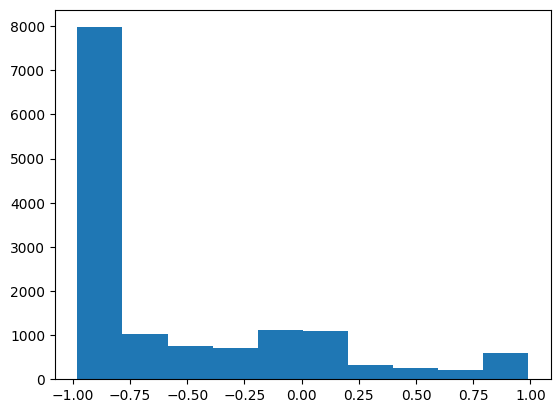

In [11]:
plt.hist(df_trump_filter["sentiment"])

### distribution of sentiments in biden dataset

(array([4605.,  874.,  668.,  684., 1194., 2075.,  764.,  577.,  678.,
        1940.]),
 array([-0.98045847, -0.78326801, -0.58607755, -0.38888709, -0.19169664,
         0.00549382,  0.20268428,  0.39987474,  0.59706519,  0.79425565,
         0.99144611]),
 <BarContainer object of 10 artists>)

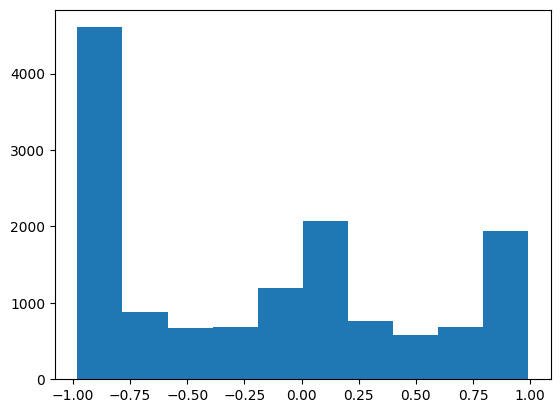

In [13]:
plt.hist(biden_shortened["sentiment"])

### change sentiment scores to verbal sentiment


In [14]:
def sentiment_category(sentiment):
    label = ''
    if(sentiment>0):
        label = 'positive'
    elif(sentiment == 0):
        label = 'neutral'
    else:
        label = 'negative'
    return(label)

biden_shortened['sentiment_category'] = biden_shortened['sentiment'].apply(sentiment_category)
df_trump_filter['sentiment_category'] = df_trump_filter['sentiment'].apply(sentiment_category)

/var/folders/_f/l9lzgfd97zd7t7js9_gjxx600000gn/T/ipykernel_2438/4047799549.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trump_filter['sentiment_category'] = df_trump_filter['sentiment'].apply(sentiment_category)


### extract politcal alignment from sentiment scores of each tweet

In [15]:
#label each tweet on whether it is biden or trump supporting
#if a tweet is negative in the trump dataset, the tweet is labeled as biden supporting (1)
#if positive in the trump dataset, it is labeled as trump supporting (-1)
def supporter_trump(sentiment_category):
    label = ''
    if(sentiment_category=="positive"):
        label = -1
    elif(sentiment_category == "negative"):
        label = 1
    else:
        label = 0
    return(label)

df_trump_filter['support_candidate'] = df_trump_filter['sentiment_category'].apply(supporter_trump)

/var/folders/_f/l9lzgfd97zd7t7js9_gjxx600000gn/T/ipykernel_2438/1539996751.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trump_filter['support_candidate'] = df_trump_filter['sentiment_category'].apply(supporter_trump)


In [16]:
#label each tweet on whether it is biden or trump supporting
#if a tweet is negative in the biden dataset, the tweet is labeled as trump supporting (1)
#if positive in the biden dataset, it is labeled as biden supporting (-1)
def supporter_biden(sentiment_category):
    label = ''
    if(sentiment_category=="positive"):
        label = 1
    elif(sentiment_category == "negative"):
        label = -1
    else:
        label = 0
    return(label)

biden_shortened['support_candidate'] = biden_shortened['sentiment_category'].apply(supporter_biden)

In [18]:
combined = pd.concat([biden_shortened, df_trump_filter])

In [19]:
combined["support_candidate"].value_counts()

support_candidate
 1    17639
-1    10479
Name: count, dtype: int64

### analyze by user

In [46]:
#group the combined dataset by user_id and get the mean of that user's tweet's support and the amount of tweets
#we are now seeing how each USER leans rather than individual tweets
#so if mean = -1 for example, all their tweets are fully trump supporting
grouped_combined = combined.groupby("user_id").agg({"support_candidate": ["mean", "count"]})
grouped_combined = grouped_combined[grouped_combined[("support_candidate", "count")]>5]
grouped_combined = grouped_combined.droplevel(axis = 1, level = 0).reset_index()
grouped_combined

,user_id,mean,count
0,2.520031e+06,0.090909,11
1,4.132841e+06,0.590164,122
2,5.474222e+06,-0.428571,7
3,7.829912e+06,0.789474,19
4,8.436472e+06,0.375000,96
...,...,...,...
1255,1.318552e+18,-1.000000,6
1256,1.318560e+18,-0.777778,9
1257,1.318591e+18,-1.000000,7
1258,1.320020e+18,0.714286,7


(array([146., 141., 108.,  71.,  54.,  94.,  75.,  96., 172., 303.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

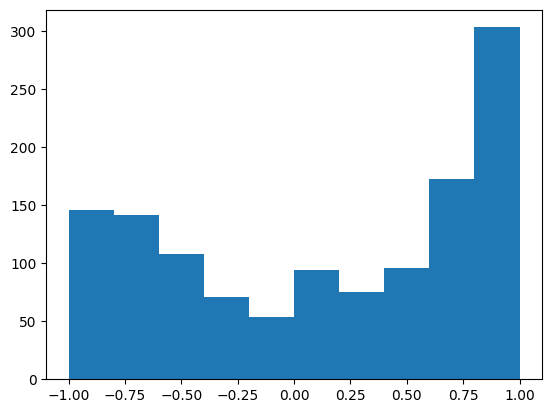

In [21]:
#distribution of the mean support candidate of the users
#we can see there are a lot of fully biden supporting users
plt.hist(grouped_combined["mean"])

### classification of user political alignment

In [90]:
#to classify USERS into who they support based of the mean of their tweets
def classify(inp):
    thres = 0.22
    if (inp >= -thres) and (inp<=thres):
        return "neutral"
    elif inp < -thres:
        return "trump"
    elif inp >thres:
        return "biden"
    else:
        return "error"

In [91]:
grouped_combined["support"] = grouped_combined["mean"].apply(classify)

In [92]:
grouped_combined["support"].value_counts()

support
biden      645
trump      461
neutral    154
Name: count, dtype: int64

In [93]:
support_by_user = grouped_combined[["user_id", "support", "mean"]]
support_by_user.columns = ["user_id", "user_support_candidate", "user_support_level"]
support_by_user

,user_id,user_support_candidate,user_support_level
0,2.520031e+06,neutral,0.090909
1,4.132841e+06,biden,0.590164
2,5.474222e+06,trump,-0.428571
3,7.829912e+06,biden,0.789474
4,8.436472e+06,biden,0.375000
...,...,...,...
1255,1.318552e+18,trump,-1.000000
1256,1.318560e+18,trump,-0.777778
1257,1.318591e+18,trump,-1.000000
1258,1.320020e+18,biden,0.714286


In [94]:
tweets_and_support = combined.merge(support_by_user, on = "user_id", how = "left")

In [108]:
neutral_tweets = tweets_and_support[tweets_and_support["user_support_candidate"] == "neutral"]

154

### data clustering

In [130]:
#separate the dataset into clusters
biden_tweets = tweets_and_support[tweets_and_support["user_support_candidate"] == "biden"]
biden_tweets_less = biden_tweets[biden_tweets['user_support_level']<0.5]
biden_tweets_more = biden_tweets[biden_tweets['user_support_level']>=0.5]

In [131]:
biden_tweets_less.shape

(2354, 8)

In [132]:
biden_tweets_more.shape

(12803, 8)

In [141]:
#good example tweet for weak biden supporter - user 117327100.0
biden_tweets_less["cleaned_tweets"].iloc[2]

"funder  napernurse already voted for  biden by  absenteeballot. plan to skip both. trim my toe nails. \n\nit's a choice between pitiful dementia patients. held my nose and voted *against* the  maga sociopath. 😬  👈\n\n bidenharrislandslide2020  bidentownhallabc"

In [152]:
#separate the dataset into clusters
trump_tweets = tweets_and_support[tweets_and_support["user_support_candidate"] == "trump"]
trump_tweets_less = trump_tweets[trump_tweets['user_support_level']>-0.5]
trump_tweets_more = trump_tweets[trump_tweets['user_support_level']<=-0.5]

In [153]:
trump_tweets_less.shape

(1149, 8)

In [154]:
trump_tweets_more.shape

(4617, 8)

In [1]:
#number of users for each cluster: 
print("biden strong: " + str(len(biden_tweets_more["user_id"].unique())))
print("biden weak: " + str(len(biden_tweets_less["user_id"].unique())))
print("neutral: " + str(len(neutral_tweets["user_id"].unique())))
print("trump strong: " + str(len(trump_tweets_more["user_id"].unique())))
print("trump weak: " + str(len(trump_tweets_less["user_id"].unique())))

NameError: name 'biden_tweets_more' is not defined

In [ ]:
biden_tweets_more.to_csv('split_data/biden_tweets_more.csv') 
biden_tweets_less.to_csv('split_data/biden_tweets_less.csv') 
neutral.to_csv('split_data/neutral.csv') 
trump_tweets_more.to_csv('split_data/trump_tweets_more.csv') 
trump_tweets_less.to_csv('split_data/trump_tweets_less.csv') 